In [1]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os
import numpy as np
import pandas as pd
from astropy.io import fits
from spectres import spectres
from scipy.signal import savgol_filter
from tqdm import tqdm  # Progress bar for loop

hdul = fits.open('SP_fuji_guad.fits')
data = hdul[1].data
data = data[data.QUALITY>=2.5]
data = data[(data.CORRECT_Z>=1.88) & (data.CORRECT_Z<=2.2667)]

In [2]:
data.shape

(777,)

In [3]:
def resample_spectra(new_wavs, spec_wavs, savgol_data):
    """Resample spectra to a new wavelength grid."""
    return spectres(new_wavs=new_wavs, spec_wavs=spec_wavs, spec_fluxes=savgol_data, fill=0, verbose=False)

def normalize(raw_data):
    """Normalize flux data by the maximum value."""
    return raw_data / raw_data.max() if raw_data.max() != 0 else raw_data

def savgol_smooth(data, window_length=5, polyorder=3):
    """Apply Savitzky-Golay smoothing filter."""
    return savgol_filter(data, window_length=window_length, polyorder=polyorder, mode='nearest')

#Fluxes0 = data.FLUX_ORIG
#wavelength0 = data.WAVE_ORIG

Fluxes = np.array([i for i in data.FLUX_ORIG]).byteswap().newbyteorder()
Wavelengths = np.array([i for i in data.WAVE_ORIG]).byteswap().newbyteorder()

new_wavs = np.arange(1800, 3267, 5)

def flux_processor(flux, wavelength,wl):
        flux_resampled = resample_spectra(new_wavs=new_wavs, spec_wavs=wavelength, savgol_data=flux)
        flux_smooth = savgol_smooth(flux_resampled, window_length=wl, polyorder=3)
        flux_smooth = flux_smooth/max(flux_smooth)

        return flux_smooth


clean_wavelength = [i/(j+1) for i,j in zip(Wavelengths,data.CORRECT_Z)]
clearn_fluxes = [flux_processor(i,j,10) for i,j in zip(Fluxes,clean_wavelength)]
df = pd.DataFrame(clearn_fluxes,columns=new_wavs)
df['ZC'] = np.array(data.CORRECT_Z).byteswap().newbyteorder()
df['ZP'] = np.array(data.PIPELINE_Z).byteswap().newbyteorder()
df['STC'] = np.array(data.CORRECT_SPECTYPE).byteswap().newbyteorder()
df['STP'] = np.array(data.PIPELINE_SPECTYPE).byteswap().newbyteorder()
df['SPEC_TARGET'] = np.array(data.SPEC_TARGET).byteswap().newbyteorder()

df = df.dropna()

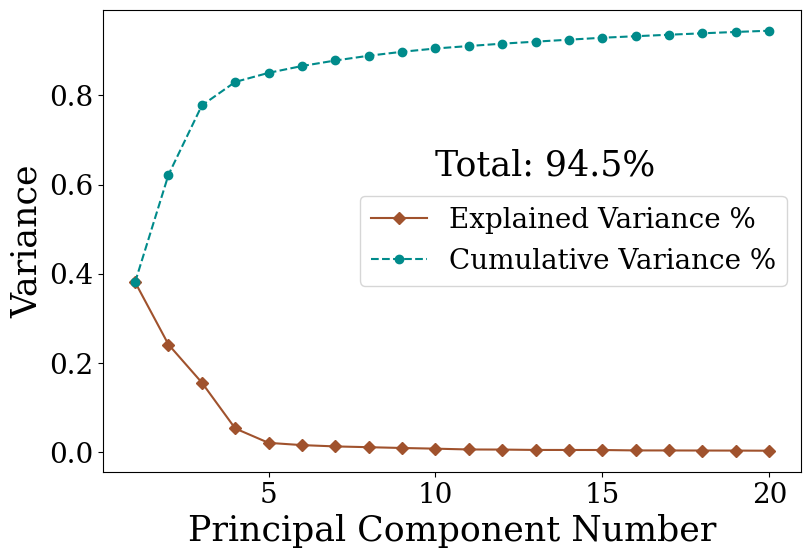

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def plot_pca_variance(components, df):
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.figure(figsize=(9,6))
    pca = PCA(n_components=components)
    pca.fit(df)
    evals = pca.explained_variance_ratio_
    evals_cs = evals.cumsum()
    pc_array = np.arange(1, components + 1)

    plt.plot(pc_array, evals, '-D', label='Explained Variance %', color='sienna')
    plt.plot(pc_array, evals_cs, '--o', label='Cumulative Variance %', color='darkcyan')
    plt.annotate(text=f'Total: {round(evals_cs[-1]*100, 1)}%', xy=(10, 0.62), xytext=(10, 0.62),size=25)
    plt.xlabel('Principal Component Number', size=25)
    plt.ylabel('Variance', size=25)
    plt.tick_params(axis='both', which='major', labelsize=20) 
    plt.legend(loc='center right',fontsize=20)

    plt.show()

plot_pca_variance(20,df.iloc[:,:-5])

In [5]:
pca = PCA(n_components=20)
pca_df = pd.DataFrame(pca.fit_transform(df.iloc[:,:-5]))

def Optimum_Cluster_Finder(dataset, kmeans_kwargs):
    silhouette_coefficients = []
    sse = []

    # Compute SSE and Silhouette coefficients for different cluster numbers
    with tqdm(total=10, desc="Computing SSE Scores") as pbar1, \
         tqdm(total=9, desc='Computing Silhouette Coefficients') as pbar2:
        for k in range(1, 11):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(dataset)
            sse.append(kmeans.inertia_)
            pbar1.update(1)
            if k > 1:
                score = silhouette_score(dataset, kmeans.labels_)
                silhouette_coefficients.append(score)
                pbar2.update(1)

    print("SSE Scores and Silhouette Coefficients Written")

    return silhouette_coefficients, sse

# Define KMeans kwargs
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# Find optimum clusters for BAL Dataset
silhouette_coefficients, sse = Optimum_Cluster_Finder(pca_df, kmeans_kwargs)

kl = KneeLocator(range(1, 11), sse, curve='convex', direction='decreasing')
print('The elbow for the Dataset is at the point: ', kl.elbow)

Computing SSE Scores:   0%|          | 0/10 [00:00<?, ?it/s]

Computing SSE Scores: 100%|██████████| 10/10 [00:00<00:00, 23.44it/s]

SSE Scores and Silhouette Coefficients Written
The elbow for the Dataset is at the point:  3


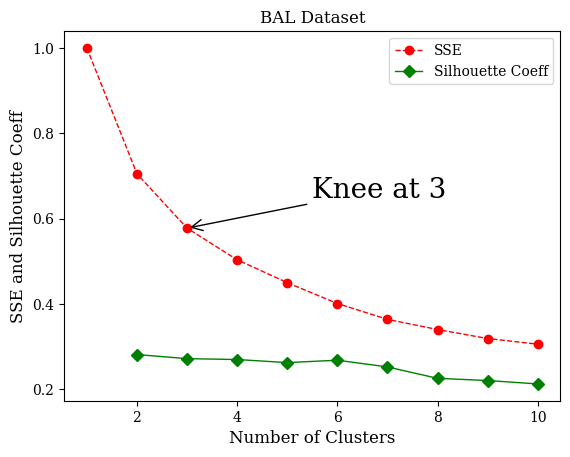

In [6]:
plt.style.use("default")
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.plot(range(1, 11), [i/max(sse) for i in sse],'--', lw=1, marker='o', label='SSE',c='red')
plt.plot(range(2, 11), silhouette_coefficients, lw=1, marker='D', label='Silhouette Coeff',c='green')
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("SSE and Silhouette Coeff", fontsize=12)
plt.title("BAL Dataset", fontsize=12)
plt.annotate(text=f'Knee at {kl.elbow}', xy=(kl.elbow, sse[2]/max(sse)), xytext=(5.5, 0.65),fontsize=20, arrowprops=dict(arrowstyle="->", connectionstyle='arc3'))
plt.legend()
plt.yticks([0.2, 0.4, 0.6, 0.8, 1])
plt.tick_params(axis='both', which='major')

plt.show()

In [7]:
def apply_pca_kmeans(df, n_components, n_clusters, kmeans_kwargs):
    pca = PCA(n_components=n_components)
    pca_df = pd.DataFrame(pca.fit_transform(df))
    kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
    model = kmeans.fit(pca_df)
    return model

# Define KMeans kwargs
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

model = apply_pca_kmeans(df.iloc[:,:-5], n_components=20, n_clusters=3, kmeans_kwargs=kmeans_kwargs)

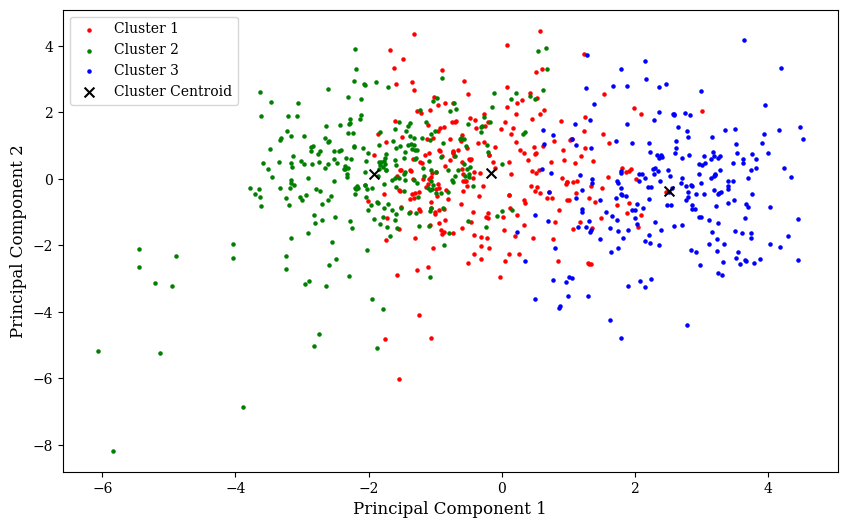

In [8]:
pca_df['Cluster'] = model.labels_
plt.figure(figsize=(10, 6))
plt.style.use('default')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.scatter(pca_df[pca_df['Cluster']==0][0], pca_df[pca_df['Cluster']==0][1], c='red', s=5,label='Cluster 1')
plt.scatter(pca_df[pca_df['Cluster']==1][0], pca_df[pca_df['Cluster']==1][1], c='green', s=5,label='Cluster 2')
plt.scatter(pca_df[pca_df['Cluster']==2][0], pca_df[pca_df['Cluster']==2][1], c='blue', s=5,label='Cluster 3')
#plt.scatter(pca_df[pca_df['Cluster']==3][0], pca_df[pca_df['Cluster']==3][1], c='darkorange', s=5,label='Cluster 3')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='x', s=50, color='black', label='Cluster Centroid')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.show()

In [9]:
df['Cluster'] = model.labels_

df_part1 = df.iloc[:, : -6]
df_last = df.iloc[:, -1]

# Combine the results
result = pd.concat([df_part1, df_last], axis=1)

mean = result.groupby('Cluster').mean()

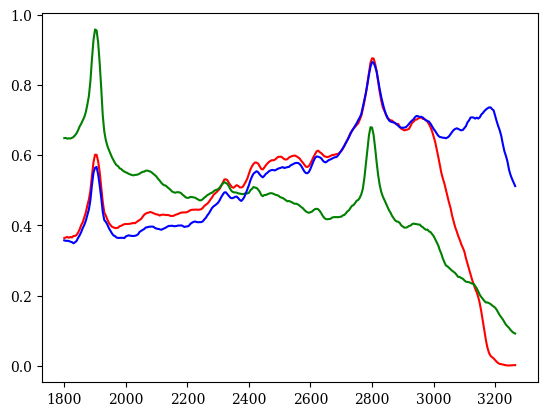

In [10]:
plt.plot(new_wavs, mean.iloc[0], label='Cluster 1', c='red')
plt.plot(new_wavs, mean.iloc[1], label='Cluster 2', c='green')
plt.plot(new_wavs, mean.iloc[2], label='Cluster 3', c='blue')
#plt.plot(new_wavs, mean.iloc[3], label='Cluster 4', c='darkorange')

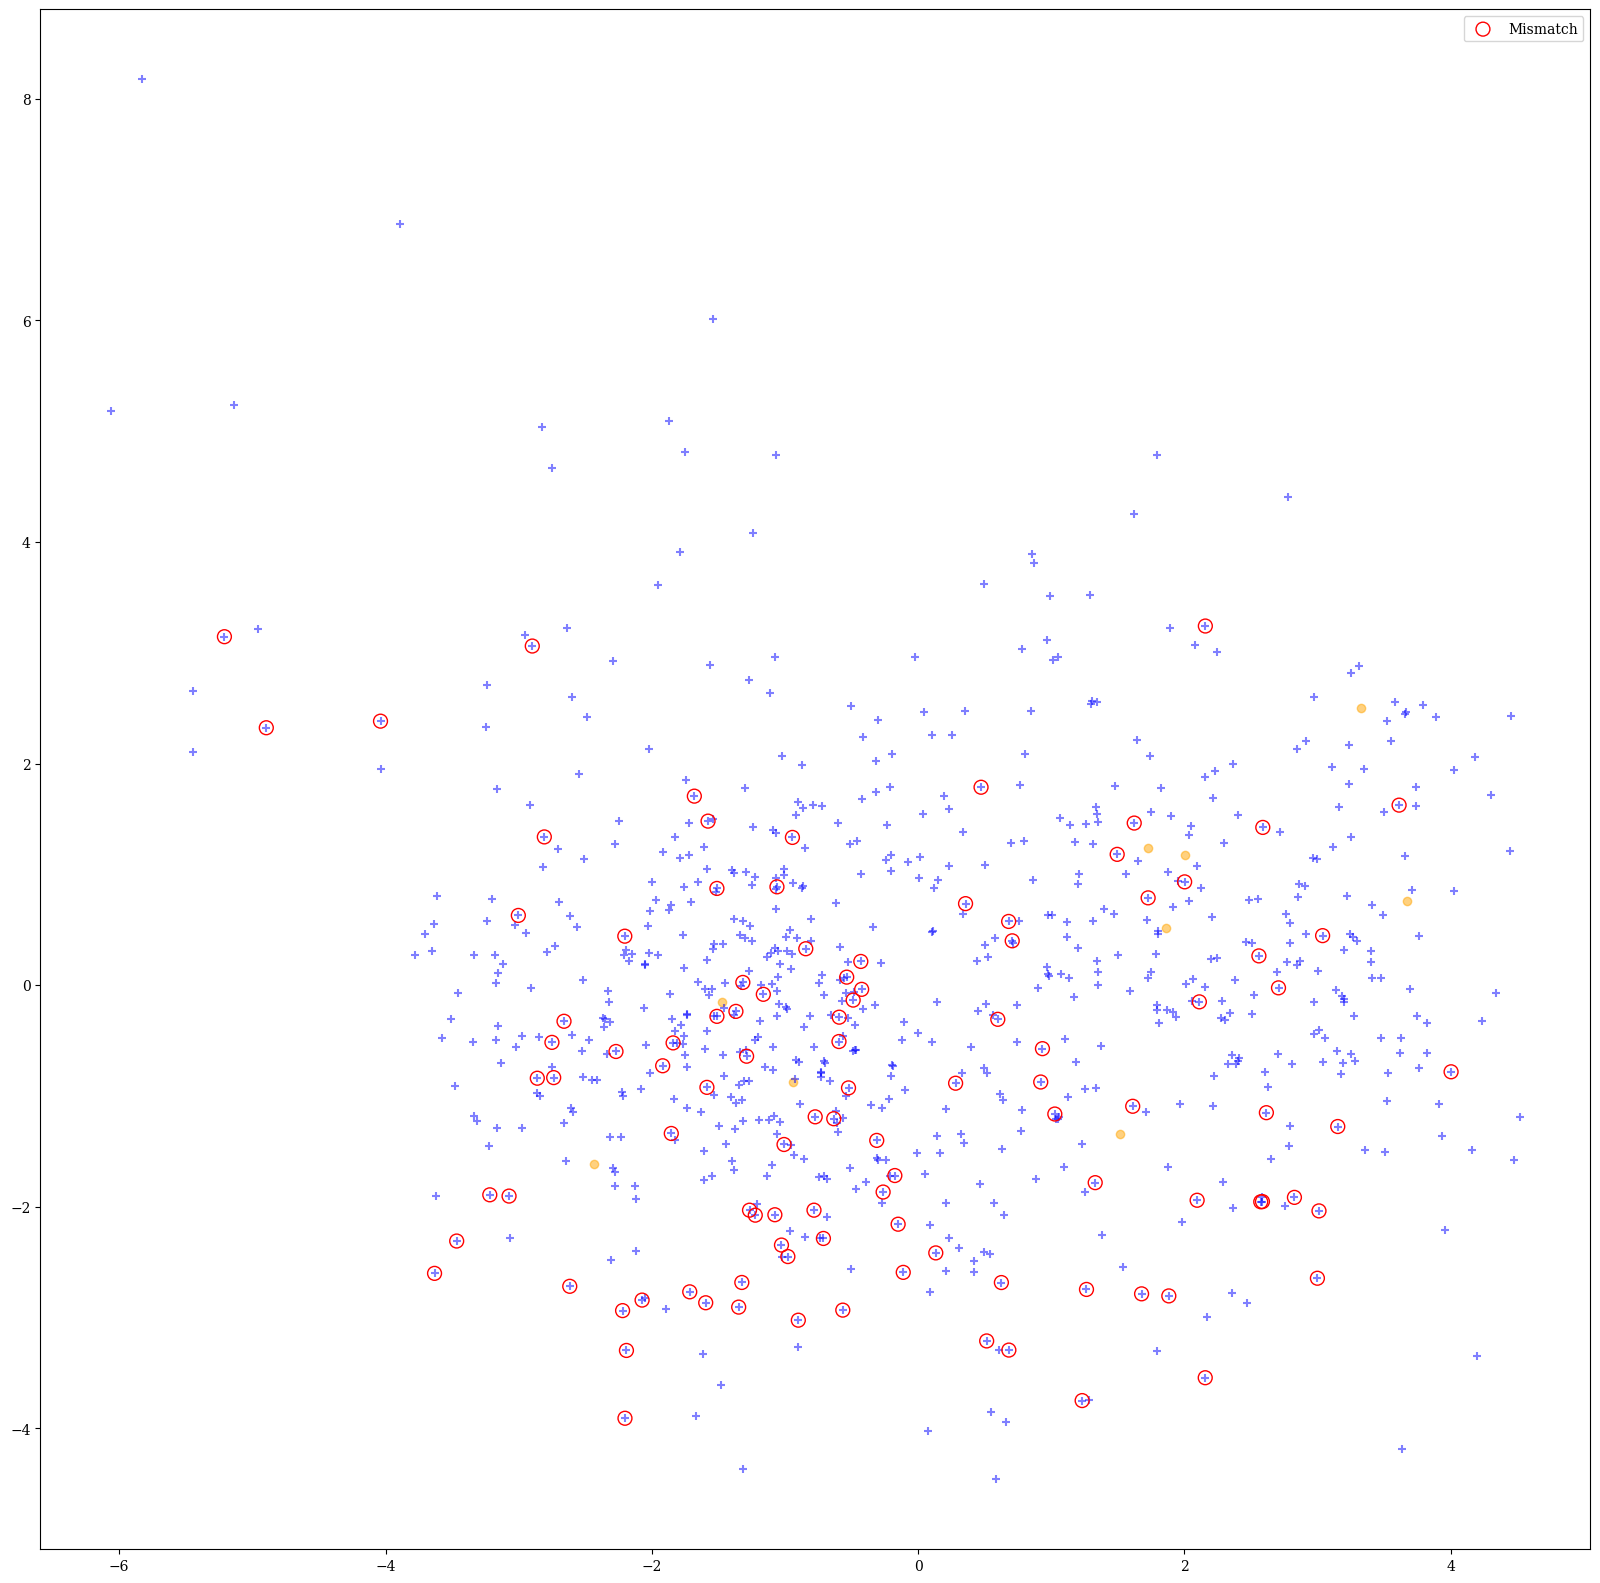

In [11]:
pca_df['STC'] = df['STC']
pca_df['STP'] = df['STP']

stars = pca_df[pca_df['STC'] == 'STAR']
galaxies = pca_df[pca_df['STC'] == 'GALAXY']
qsos = pca_df[pca_df['STC'] == 'QSO']
plt.figure(figsize=(20,20))
plt.scatter(galaxies[0], galaxies[1] * -1, marker='o', alpha=0.5, color='orange')
#plt.scatter(stars[0], stars[1] * -1, marker='x', alpha=0.5, color='green')
plt.scatter(qsos[0], qsos[1] * -1, marker='+', alpha=0.5, color='blue')

# Highlight mismatched points
mismatched_qso = qsos[qsos['STC'] != qsos['STP']]
plt.scatter(mismatched_qso[0], mismatched_qso[1] * -1, facecolors='none', edgecolors='red', s=100, label='Mismatch')

import seaborn as sns
#sns.scatterplot(data=pca_df, x=0, y=1, hue='STC')

plt.legend()
plt.show()